In [1]:
import io
import re
import sys
import json
import math
import random
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import multiprocessing
import gensim

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split



In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/ХакМэрМосквы2023/"

In [3]:
classes = {
    "__label__NORMAL" :     "Нормальный",
    "__label__INSULT" :     "Оскорбление",
    "__label__THREAT" :     "Угроза",
    "__label__OBSCENITY" :  "Непристойность",
}

classes_key = dict([(key, it) for it, key in enumerate(classes.keys())])


In [4]:
classes_key

{'__label__NORMAL': 0,
 '__label__INSULT': 1,
 '__label__THREAT': 2,
 '__label__OBSCENITY': 3}

In [5]:
word2vec = Word2Vec.load(PATH + "Models/w2v/tweets_model.w2v")


In [6]:
def split(input_text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ', outlen=50):

    input_text = input_text.lower()

    translate_dict = {c: split for c in filters}
    translate_map = str.maketrans(translate_dict)
    input_text = input_text.translate(translate_map)

    seq = input_text.split(split)
    elem = [i for i in seq if i and i in word2vec.wv]
    return (elem + ["" for _ in range(outlen - len(elem))])[:outlen]


def vectorizator(x, outlen=50):
    return np.array([split(elem) for elem in x], dtype=np.str_)


def embedding(x, maxlen=50):
    result = np.zeros(shape=[x.shape[0], maxlen, word2vec.wv.vector_size], dtype=np.float32)

    for i, text in enumerate(x):
        
        index = 0
        for word in text:

            if word in word2vec.wv:
                result[i, index, :] = word2vec.wv[word]
                index += 1

    return result

In [19]:

unit = 64

inp = layers.Input(shape=(50, 200))

x = layers.Bidirectional(layers.LSTM(unit))(inp)
out = layers.Dense(4, activation=activations.sigmoid)(x)

model = keras.Model(inputs=inp, outputs=out)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=PATH + "/tmp/checkpoint/Модерация/",
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 200)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 136,196
Trainable params: 136,196
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model.load_weights(model_checkpoint_callback.filepath)

In [21]:
class TextBatchGenerator():
    def __init__(self, path_to_data, batch_size) -> None:
        super().__init__()
        self.chunks = pd.read_csv(path_to_data, delimiter=',', chunksize=batch_size)

    def __call__(self):
        for chunk in self.chunks:
            chunk = self.chunks.get_chunk()
            X_batch = chunk.iloc[:, 0]
            X_batch = vectorizator(X_batch)
            X_batch = embedding(X_batch)

            y_batch = chunk.iloc[:, 1:]
            y_batch = np.array(y_batch)

            yield X_batch, y_batch


In [22]:


dataset = TextBatchGenerator(PATH + "toxic.csv", batch_size=50)()

history = model.fit(dataset, epochs=20, callbacks=[model_checkpoint_callback], steps_per_epoch=10)

Epoch 1/20
10/10 [==============================] - 6s 119ms/step - loss: 0.5567 - accuracy: 0.6780
Epoch 2/20
10/10 [==============================] - 1s 118ms/step - loss: 0.3758 - accuracy: 0.7940
Epoch 3/20
10/10 [==============================] - 1s 119ms/step - loss: 0.2512 - accuracy: 0.8560
Epoch 4/20
10/10 [==============================] - 1s 125ms/step - loss: 0.3004 - accuracy: 0.8060
Epoch 5/20
10/10 [==============================] - 2s 217ms/step - loss: 0.2665 - accuracy: 0.8340
Epoch 6/20
10/10 [==============================] - 2s 214ms/step - loss: 0.2480 - accuracy: 0.8140
Epoch 7/20
10/10 [==============================] - 1s 124ms/step - loss: 0.2260 - accuracy: 0.8280
Epoch 8/20
10/10 [==============================] - 1s 111ms/step - loss: 0.2302 - accuracy: 0.8380
Epoch 9/20
10/10 [==============================] - 1s 121ms/step - loss: 0.2004 - accuracy: 0.8520
Epoch 10/20
10/10 [==============================] - 1s 121ms/step - loss: 0.1949 - accuracy: 0.8820

In [23]:
X_test = []

for data in dataset:
     X_test += data

In [30]:
len(X_test)

4564

In [24]:
model.evaluate(X_test[0], X_test[1])

2/2 [==============================] - 1s 42ms/step - loss: 0.1361 - accuracy: 0.9200


[0.13606512546539307, 0.9200000166893005]

<ipython-input-37-9344e6469537>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


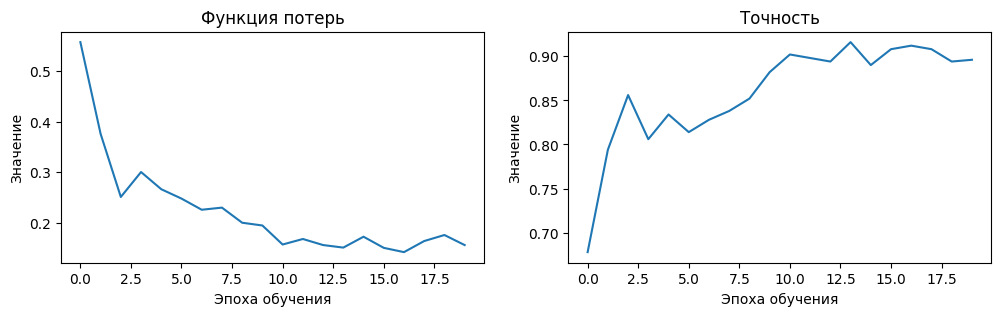

In [37]:

fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
plt.title("Функция потерь")
plt.xlabel("Эпоха обучения")
plt.ylabel("Значение")
plt.plot(history.history["loss"], label="Функция потерь")
plt.subplot(1, 2, 2)
plt.title("Точность")
plt.xlabel("Эпоха обучения")
plt.ylabel("Значение")
plt.plot(history.history["accuracy"], label="Точность")

fig.set_figwidth(12)
fig.set_figheight(3) 


In [26]:
texts1 = [
    "Просто говно параша какое-то Ужас!!! Верните деньги, сервис просто невыносим.", 
    "Плохой постамат, сотрудники совершенно не спсобны выполнять свою работу. Расположение не удобное, сложно найти вход.",
    "Очень хороший сервис, приятные сотрудники. Всё быстро и качественно.",
    "Замечательный отель. Наивысшая оценка. Просто поражает как сотрудники справляются со своей работой"
]
labels1 = [0, 1, 1, 1]

texts1 = np.array(texts1)
labels1 = np.array(labels1)

In [27]:

def predict(texts):

    vectors = vectorizator(texts)
    wvectors = embedding(vectors)
    predicted = model.predict(wvectors, verbose=0)

    return predicted


predicted = predict(texts1)
pd.DataFrame(np.column_stack([texts1, predicted, labels1]))

,0,1,2,3,4,5
0,Просто говно параша какое-то Ужас!!! Верните д...,0.51156694,0.47119427,0.026398813,0.029383054,0
1,"Плохой постамат, сотрудники совершенно не спсо...",0.9883231,0.0062286314,0.0065951245,0.006037808,1
2,"Очень хороший сервис, приятные сотрудники. Всё...",0.9952347,0.0040502734,0.002144152,0.0047268574,1
3,Замечательный отель. Наивысшая оценка. Просто ...,0.9895182,0.009051136,0.004101937,0.006051026,1


In [28]:
vectors = embedding(vectorizator(texts1))
predicted = model.predict(vectors, verbose=0)
pd.DataFrame(np.column_stack([texts1, predicted, labels1]))

,0,1,2,3,4,5
0,Просто говно параша какое-то Ужас!!! Верните д...,0.51156694,0.47119427,0.026398813,0.029383054,0
1,"Плохой постамат, сотрудники совершенно не спсо...",0.9883231,0.0062286314,0.0065951245,0.006037808,1
2,"Очень хороший сервис, приятные сотрудники. Всё...",0.9952347,0.0040502734,0.002144152,0.0047268574,1
3,Замечательный отель. Наивысшая оценка. Просто ...,0.9895182,0.009051136,0.004101937,0.006051026,1
